# NumPy and Pandas

In the Python Spark API, the work of distributed computing over the DataFrame is done on many executors (the Spark term for workers) inside Java virtual machines (JVM). Most calls to `pyspark` are passed to a Java process via the `py4j` library. The user can also ask for data inside the JVM to be brought over to the Python driver (the Spark term for the client application). When dealing with _tiles_, the driver will receive this data as a lightweight wrapper object around a NumPy ndarray. It is also possible to write lambda functions against NumPy arrays and evaluate them in the Spark DataFrame.

## Performance Considerations

When working with large, distributed datasets in Spark, attention is required when invoking _actions_ on the data. In general, _transformations_ are lazily evaluated in Spark, meaning the code runs fast and it doesn't move any data around. But _actions_ cause the evaluation to happen, meaning all the lazily planned _transformations_ are going to be computed and data is going to be processed and moved around. In general, if a [`pyspark` function](https://spark.apache.org/docs/2.3.2/api/python/pyspark.sql.html) returns a DataFrame, it is probably a _transformation_, and if not, it is an _action_.

When many _actions_ are invoked, a lot of data can flow from executors to the driver. In `pyspark`, the data then has to move from the driver JVM to the Python process running the driver. When that happens, if there are any _tiles_ in the data, they will be converted to a Python [`Tile`](https://github.com/locationtech/rasterframes/blob/develop/pyrasterframes/src/main/python/pyrasterframes/rf_types.py) object. In practical work with Earth observation data, the _tiles_ are frequently 256 by 256 arrays, which may be 100kb or more each. Individually they are small, but a DataFrame can easily have dozens of such _tile_ columns and millions of rows.

All of this discussion reinforces two important principles for working with Spark: understanding the cost of an _action_ and using @ref:[aggreates](aggregation.md), summaries, or samples to manage the cost of _actions_.

## The `Tile` Class

In Python, _tiles_ are represented with the `rf_types.Tile` class. This is a NumPy `ndarray` with two dimensions, along with some additional metadata allowing correct conversion to the GeoTrellis @ref:[cell type](nodata-handling.md#cell-types).



In [1]:
from pyrasterframes.rf_types import Tile
import numpy as np

t = Tile(np.random.randn(4, 4))
print(str(t))

Tile(dimensions=[4, 4], cell_type=CellType(float64, nan), cells=
[[-0.8835089740705196 -0.9563640802493385 -1.090914934802266
  0.11793945605550586]
 [1.1182942643910954 0.1238418087931534 -0.5489130786453579
  0.7251883836764199]
 [-0.5550715771991496 -0.7707291984888621 -0.014389188807490978
  -0.6581746388238282]
 [0.5981245663952416 0.8028785637444782 -0.6060069085187807
  -0.19279328487806968]])



You can access the NumPy array with the `cells` member of `Tile`.



In [2]:
t.cells.shape, t.cells.nbytes

((4, 4), 128)


## DataFrame `toPandas`

As discussed in the @ref:[raster writing chapter](raster-write.md#dataframe-samples), a pretty display of Pandas DataFrame containing _tiles_ is available by importing the `rf_ipython` submodule. In addition, as discussed in the @ref:[vector data chapter](vector-data.md), any geometry type in the Spark DataFrame will be converted into a Shapely geometry. Taken together, we can easily get the spatial information and raster data as a NumPy array, all within a Pandas DataFrame.



In [3]:
import pyrasterframes
from pyrasterframes.utils import create_rf_spark_session
from pyrasterframes.rasterfunctions import *
from IPython.display import display
spark = create_rf_spark_session()

In [4]:
import pyrasterframes.rf_ipython
from pyspark.sql.functions import lit, col

cat = spark.read.format('aws-pds-modis-catalog').load() \
        .filter(
            (col('granule_id') == 'h11v04') &
            (col('acquisition_date') > lit('2018-02-19')) &
            (col('acquisition_date') < lit('2018-02-22'))
        )

spark_df = spark.read.raster(cat, catalog_col_names=['B01']) \
                .select(
                    'acquisition_date',
                    'granule_id',
                    rf_tile('B01').alias('tile'),
                    rf_geometry('B01').alias('tile_geom')
                    )

pandas_df = spark_df.limit(10).toPandas()
pandas_df.iloc[0].apply(lambda v: type(v))

acquisition_date    <class 'pandas._libs.tslibs.timestamps.Timesta...
granule_id                                              <class 'str'>
tile                           <class 'pyrasterframes.rf_types.Tile'>
tile_geom                  <class 'shapely.geometry.polygon.Polygon'>
Name: 0, dtype: object


## User Defined Functions

As we demonstrated with @ref:[vector data](vector-data.md#shapely-geometry-support), we can also make use of the `Tile` type to create [user-defined functions (UDF)](https://spark.apache.org/docs/2.3.2/api/python/pyspark.sql.html#pyspark.sql.functions.udf) that can take a _tile_ as input, return a _tile_ as output, or both. Here is a trivial and **inefficient** example of doing both. A serious performance implication of user defined functions in Python is that all the executors must move the Java objects to Python, evaluate the function, and then move the Python objects back to Java. Use the many @ref:[built-in functions](reference.md) wherever possible, and ask the [community](https://gitter.im/locationtech/rasterframes) if you have an idea for a function that should be included.

We will demonstrate an example of creating a UDF that is logically equivalent to a built-in function. We'll quickly show that the resulting _tiles_ are approximately equivalent. The reason they are not exactly the same is that one is computed in Python and the other is computed in Java.



In [5]:
from pyrasterframes.rf_types import TileUDT
from pyspark.sql.functions import udf

@udf(TileUDT())
def my_udf(t):
    import numpy as np
    return Tile(np.log1p(t.cells))

udf_df = spark_df.limit(1).select(
            my_udf('tile').alias('udf_result'),
            rf_log1p('tile').alias('built_in_result')
        ).toPandas()

row = udf_df.iloc[0]
diff = row['udf_result'] - row['built_in_result']
print(type(diff))
np.abs(diff.cells).max()

<class 'pyrasterframes.rf_types.Tile'>


4.767482870704498e-07


We can also inspect an image of the difference between the two _tiles_, which is just random noise. Both _tiles_ have the same structure of NoData, as exhibited by the white areas.



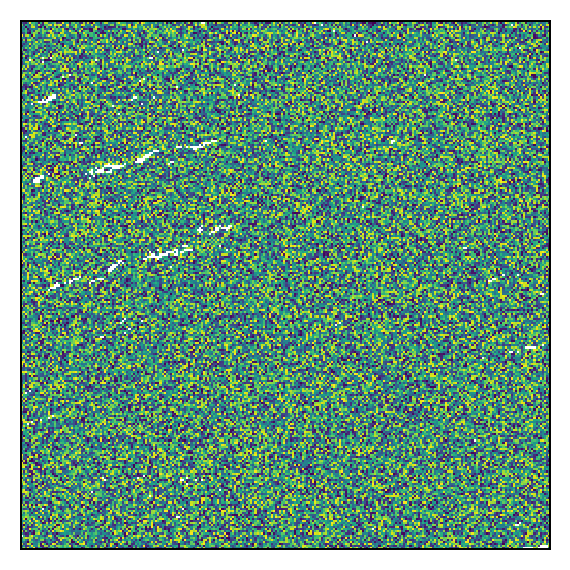

In [6]:
diff.show(0, 100)


## Creating a Spark DataFrame

You can also create a Spark DataFrame with a column full of `Tile` objects or Shapely geomtery objects.

The example below will create a Pandas DataFrame with ten rows of noise _tiles_ and random `Point`s. We will then create a Spark DataFrame from it.



In [7]:
import pandas as pd
from shapely.geometry import Point

pandas_df = pd.DataFrame([{
    'tile': Tile(np.random.randn(100, 100)),
    'geom': Point(-90 + 90 * np.random.random((2, 1)))
    } for _ in range(10)
])

spark_df = spark.createDataFrame(pandas_df)

spark_df.printSchema()
spark_df.count()

root
 |-- tile: tile (nullable = true)
 |-- geom: point (nullable = true)



10